## SERIES DE TIEMPO PARA PRONÓSTICOS EN ECONOMÍA Y FINANZAS
### CLASE 6: Dinámica de Varianza Condicional

<div style="text-align: right"> Elaborado por Jorge Guerra </div>
<div style="text-align: right"> @jguerrae18 </div>
<div style="text-align: right"> ja.guerrae@uniandes.edu.co </div>

In [1]:
import warnings 
warnings.filterwarnings("ignore") #código para ignorar los anuncios de alertas

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

> **¿Qué haremos el día de hoy?**


El análisis se basará en una sola variable. La tasa de desempleo mensual en Colombia desde enero del año 2001 hasta el mes de noviembre del año 2019. La fuente de datos es el Departamento Administrativo Nacional de Estadística y la tasa de desempleo es la total Nacional. el código se dividirá en las siguientes secciones:


1. Exploración inicial
2. Modelos de brecha: AR(1).
3. Prónosticos fuera de muestra.
4. Criterios de selección.
5. Modelo estacionales y prónostico fuera de muestra.
6. Criterios de Selección de los modelos
---


In [2]:
#IMPORTANDO LOS PAQUETES MÁS IMPORTANTES. RECORDANDO

import pandas as pd #Pandas para el procesamiento de los datos
import matplotlib.pyplot as plt #Matplotlib para gráficar
import seaborn as sns #Seaborn para gráficar
import numpy as np #Numpy para el procesamiento númerico

In [3]:
df = pd.read_excel("precios.xlsx") #leer base de datos

In [4]:
df["FECHA"] = pd.to_datetime(df["FECHA"]) #convertir en formato fecha
df = df.set_index("FECHA") #fijar la fecha como un índice ( ya no como columna)
df.index.freq = "MS" #Fijar frecuencia mensual

In [5]:
df.describe() #descripción de la variable

,PRECIO
count,355.000000
mean,49.267630
std,33.175765
min,10.185714
25%,19.525185
50%,38.904091
75%,71.113330
max,134.564783


## 1. Exploración inicial

In [6]:
#CREEMOS UNA NUEVA VARIABLE CON LOS RETORNOS LOGARITMICOS MENSUALES Y TAMBIÉN LLEVAMOS LA MISMA PERO ELEVADA AL CUADRADO

df["RETP"] = np.log(df["PRECIO"]).diff(1)*100
df["RETP2"] = df["RETP"]**2
df = df.dropna()

In [7]:
df

,PRECIO,RETP,RETP2
FECHA,,,
1990-02-01,19.589500,-2.703687,7.309924
1990-03-01,18.641818,-4.958636,24.588073
1990-04-01,17.320526,-7.351506,54.044635
1990-05-01,17.126667,-1.125559,1.266882
1990-06-01,15.904286,-7.404809,54.831194
...,...,...,...
2019-03-01,67.027619,3.950212,15.604171
2019-04-01,71.628571,6.638928,44.075362
2019-05-01,70.303043,-1.867895,3.489030


Text(0.5, 1.0, 'RETORNOS MENSUALES AL CUADRADO')

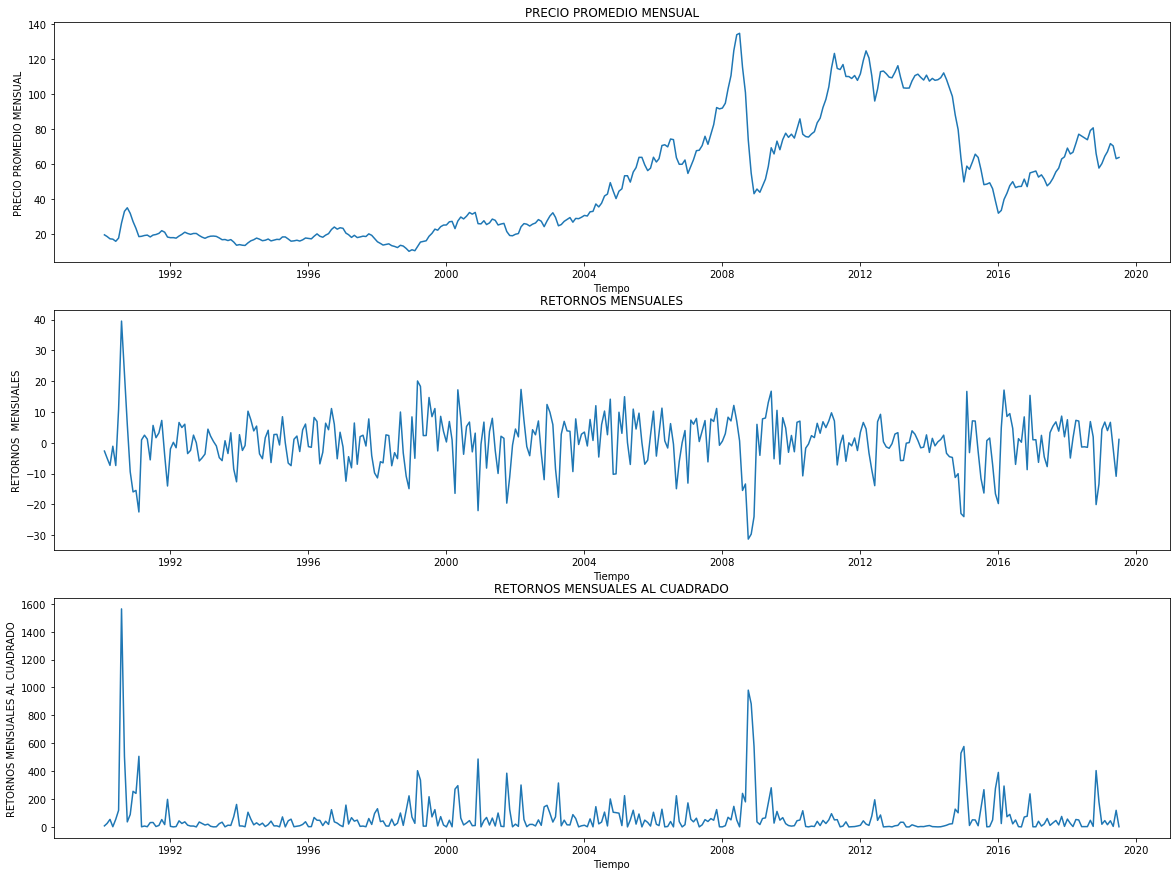

In [8]:
#Inspección gráfica

fig, ax =plt.subplots(3,1, figsize=(20, 15), sharex = False)

#PRECIO
sns.lineplot(y = df.PRECIO, x = df.index, dashes= True, err_style ="bars", ax = ax[0])
ax[0].set_xlabel('Tiempo', fontsize=10)
ax[0].set_ylabel('PRECIO PROMEDIO MENSUAL', fontsize=10)
ax[0].set_title("PRECIO PROMEDIO MENSUAL", fontsize=12)

#RETORNOS
sns.lineplot(y = df.RETP, x = df.index, dashes= True, err_style ="bars", ax = ax[1])
ax[1].set_xlabel('Tiempo', fontsize=10)
ax[1].set_ylabel('RETORNOS  MENSUALES', fontsize=10)
ax[1].set_title("RETORNOS MENSUALES", fontsize=12)


#RETORNOS2
sns.lineplot(y = df.RETP2, x = df.index, dashes= True, err_style ="bars", ax = ax[2])
ax[2].set_xlabel('Tiempo', fontsize=10)
ax[2].set_ylabel('RETORNOS MENSUALES AL CUADRADO', fontsize=10)
ax[2].set_title("RETORNOS MENSUALES AL CUADRADO", fontsize=12)



In [9]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf #autocorrelación, autocorrelación parcial

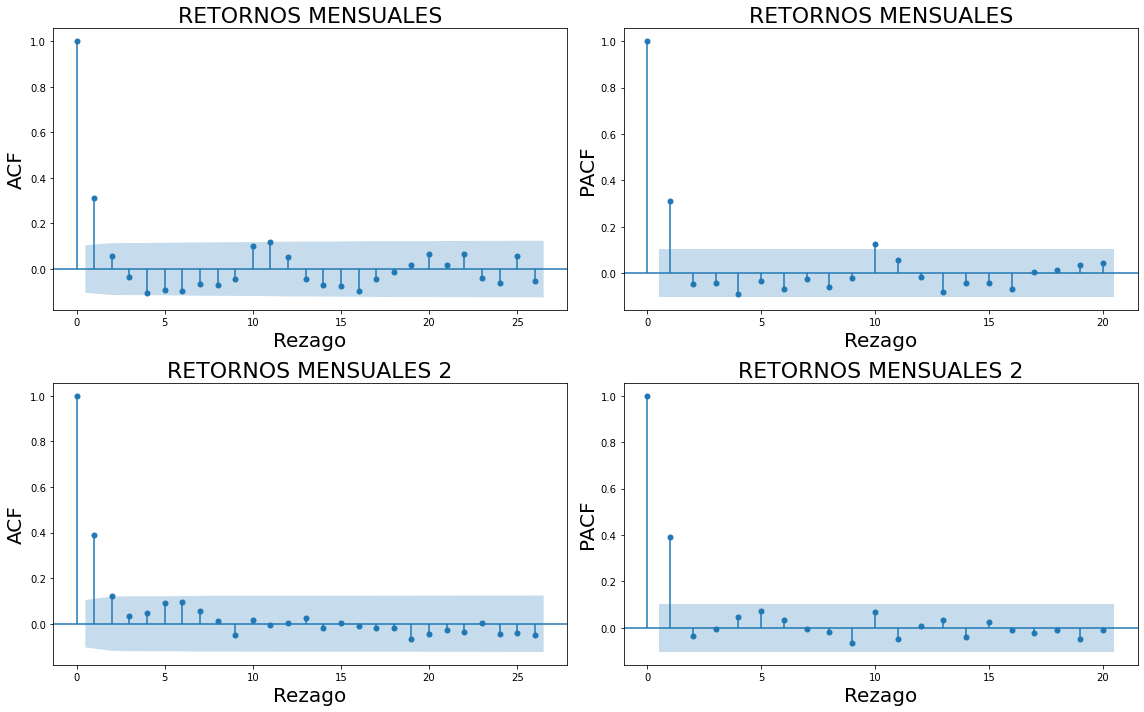

In [10]:
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

#RETORNOS MENSUALES
plot_acf(df.RETP, ax = ax1, alpha = 0.05)
ax1.set_xlabel('Rezago', fontsize=20)
ax1.set_ylabel('ACF', fontsize=20)
ax1.set_title("RETORNOS MENSUALES", fontsize=22)


plot_pacf(df.RETP, ax = ax2, lags  = 20, alpha = 0.05, method = "ols")
ax2.set_xlabel('Rezago', fontsize=20)
ax2.set_ylabel('PACF', fontsize=20)
ax2.set_title("RETORNOS MENSUALES", fontsize=22)

#RETORNOS MENSUALES AL CUADRADO
plot_acf(df.RETP2, ax = ax3, alpha = 0.05)
ax3.set_xlabel('Rezago', fontsize=20)
ax3.set_ylabel('ACF', fontsize=20)
ax3.set_title("RETORNOS MENSUALES 2", fontsize=22)


plot_pacf(df.RETP2, ax = ax4, lags  = 20, alpha = 0.05, method = "ols")
ax4.set_xlabel('Rezago', fontsize=20)
ax4.set_ylabel('PACF', fontsize=20)
ax4.set_title("RETORNOS MENSUALES 2", fontsize=22)


plt.tight_layout()
plt.show()

## 2. Estimación modelo ARCH

In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [12]:
model1 = ARIMA(df.RETP, order=(1, 0, 0)).fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                   RETP   No. Observations:                  354
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1237.426
Date:                Wed, 23 Feb 2022   AIC                           2480.853
Time:                        10:33:43   BIC                           2492.461
Sample:                    02-01-1990   HQIC                          2485.471
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3246      0.642      0.505      0.613      -0.934       1.583
ar.L1          0.3116      0.039      8.040      0.000       0.236       0.388
sigma2        63.6194      3.791     16.782      0.0

In [13]:
residuales2 = model1.resid**2 #errores al cuadrado ~ proxy de la varianza
residuales = model1.resid

### Inspección gráfica

Text(0, 0.5, 'PACF')

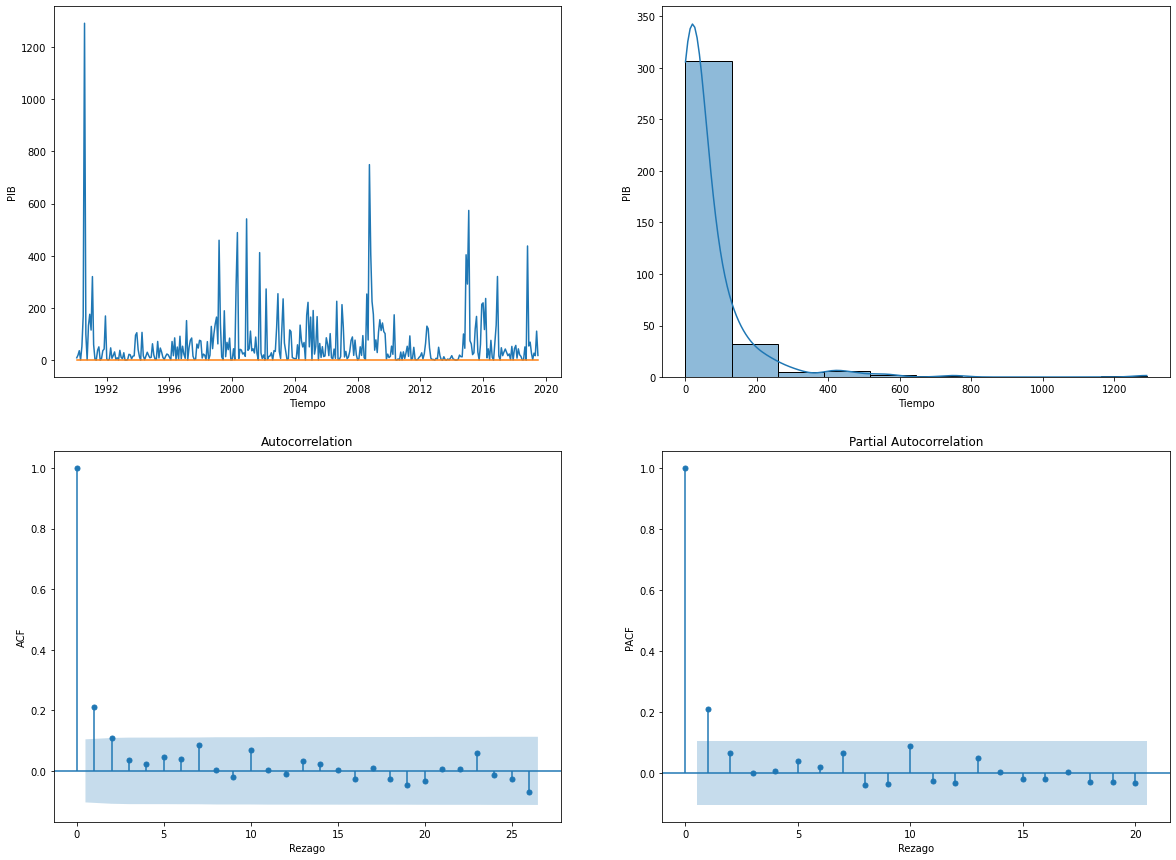

In [14]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = residuales2, x = residuales2.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(residuales2)),  x = residuales2.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('PIB', fontsize=10)


sns.histplot(x = residuales2 , ax=ax[0,1], bins = 10, kde = True)
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PIB', fontsize=10)


#FIG 1
plot_acf(residuales2, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(residuales2, ax = ax[1,1], lags  = 20, alpha = 0.05, method = "ols")
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10) 

### Q-test

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox as QTest

In [16]:
A = pd.DataFrame() #creamos un dataframe vacío

for i in range(5,16,5): #en un rango del 1 al 15 de 5 en 5 (...)
    B  = QTest(residuales2, lags=[i], return_df=True) #Estimamos la prueba para cada uno de los rezagos y (...)
    A = pd.concat([A,B]) # la concatenamos verticalmente con las demás pruebas

A

,lb_stat,lb_pvalue
5,21.132010,0.000765
10,26.084131,0.003629
15,26.725221,0.031057


Si tiene efectos de varianza condicional, ahora vale la pena estimarlo de manera conjunta.

## ARCH

In [17]:
import arch as arch

In [18]:
arch1 = arch.univariate.ARX(df.RETP, lags = [1], volatility = arch.univariate.GARCH(1, 0, 0) ).fit()
print("\n", arch1.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9981.555544548408
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1255.372104811153
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1371.223542418261
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1223.4992716817376
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1222.7415951975643
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1221.079465795723
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1220.9143695382156
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1220.9005124144023
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1220.9002665605472
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1220.900248835186
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1220.900248835194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1220.900248835186
            Iterations: 11
            Function evaluations: 60
            Gradient evaluation

¿Cómo se ve la varianza predicha vs la observada?

In [19]:
varianza_arch1 = residuales2 - arch1.resid

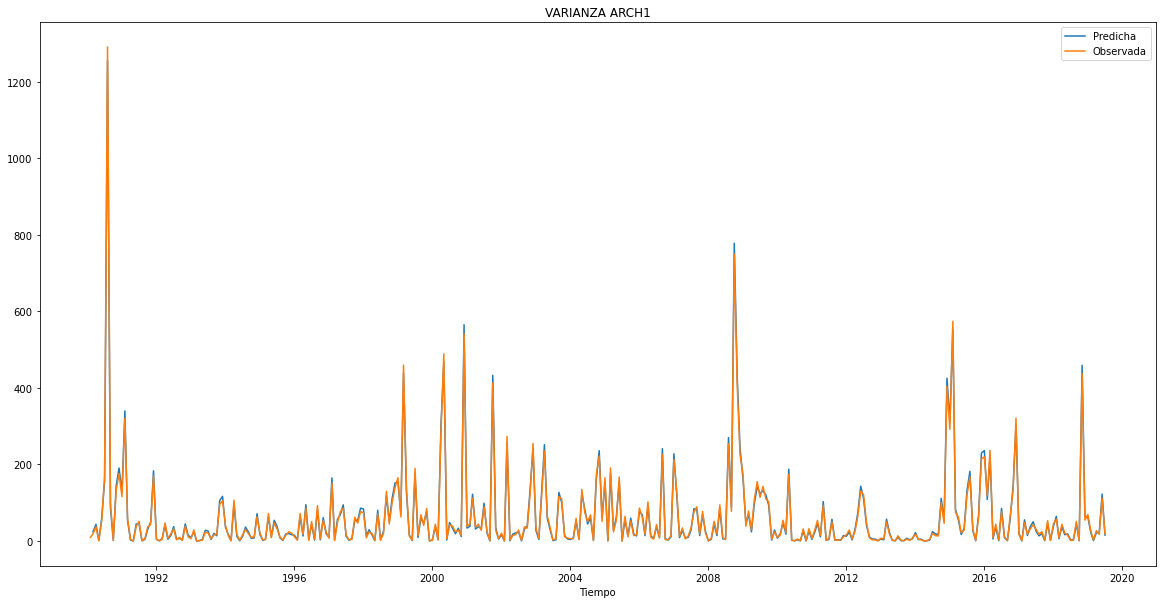

In [20]:
#Inspección gráfica

fig, ax =plt.subplots(1,1, figsize=(20, 10), sharex = False)

#PRECIO
sns.lineplot(y = varianza_arch1, x = varianza_arch1.index, dashes= True, err_style ="bars", ax = ax)
sns.lineplot(y = residuales2, x = residuales2.index, dashes= True, err_style ="bars", ax = ax)
ax.set_xlabel('Tiempo', fontsize=10)
ax.set_title("VARIANZA ARCH1", fontsize=12)
ax.legend(["Predicha", "Observada"])

Veamos el comportamiento de los errores

In [21]:
arch1_resid = arch1.resid
arch1_std = arch1.conditional_volatility
arch1_resid_std = arch1_resid / arch1_std
arch1_resid_std = arch1_resid_std[1:]

In [22]:
import statsmodels.api as sm

Text(0.5, 1.0, 'ACF Errores Estandarizados^2')

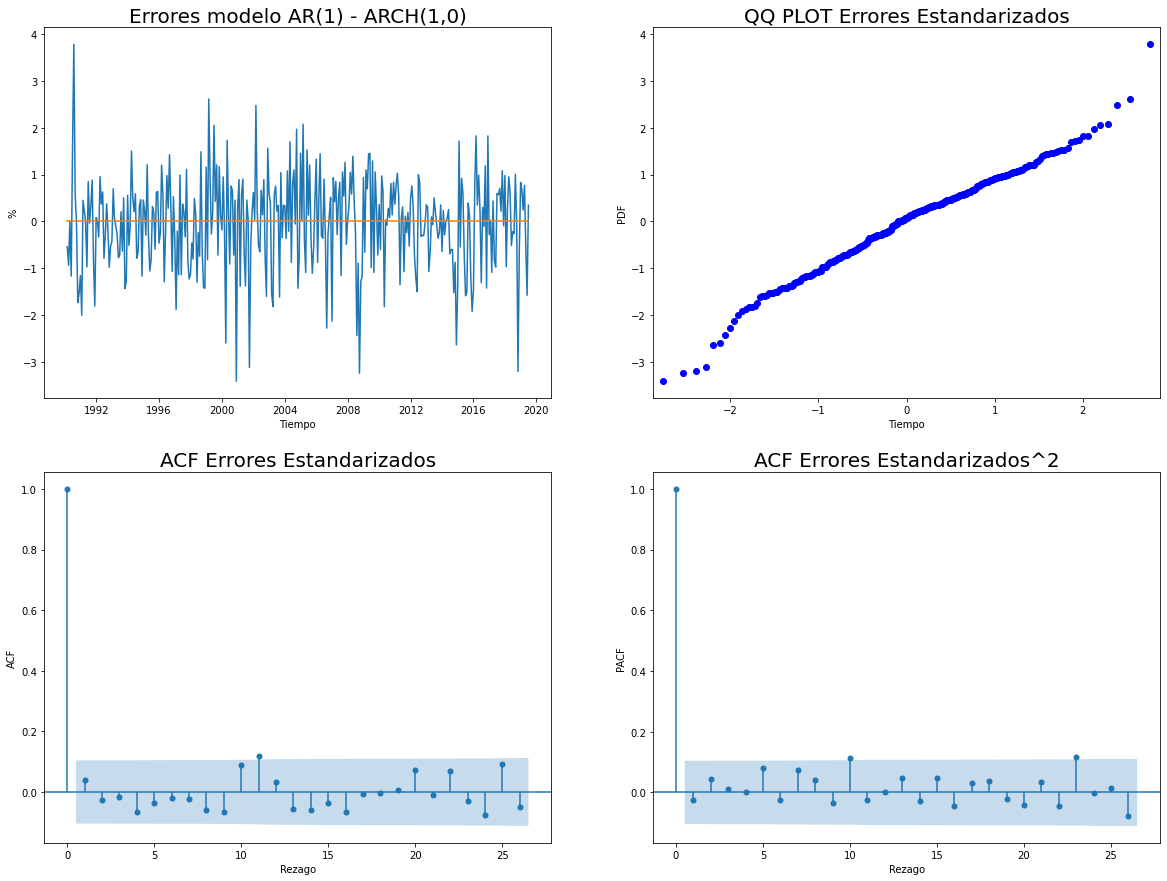

In [23]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = arch1_resid_std , x = arch1_resid_std.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(arch1_resid_std)),  x = arch1_resid_std.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('%', fontsize=10)
ax[0,0].set_title('Errores modelo AR(1) - ARCH(1,0)', fontsize=20)


sm.qqplot(arch1_resid_std, ax=ax[0,1])
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PDF', fontsize=10)
ax[0,1].set_title('QQ PLOT Errores Estandarizados', fontsize=20)


#FIG 1
plot_acf(arch1_resid_std, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)
ax[1,0].set_title('ACF Errores Estandarizados', fontsize=20)

#FIG 2
plot_acf(arch1_resid_std**2, ax = ax[1,1], alpha = 0.05)
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10) 
ax[1,1].set_title('ACF Errores Estandarizados^2', fontsize=20)

### Q-test

In [24]:
A = pd.DataFrame() #creamos un dataframe vacío

for i in range(5,16,5): #en un rango del 1 al 15 de 5 en 5 (...)
    B  = QTest(arch1_resid_std**2, lags=[i], return_df=True) #Estimamos la prueba para cada uno de los rezagos y (...)
    A = pd.concat([A,B]) # la concatenamos verticalmente con las demás pruebas

A

,lb_stat,lb_pvalue
5,3.344461,0.647042
10,11.301081,0.334547
15,13.463971,0.566508


Text(0.5, 1.0, 'VARIANZA DEL MODELO ARCH1')

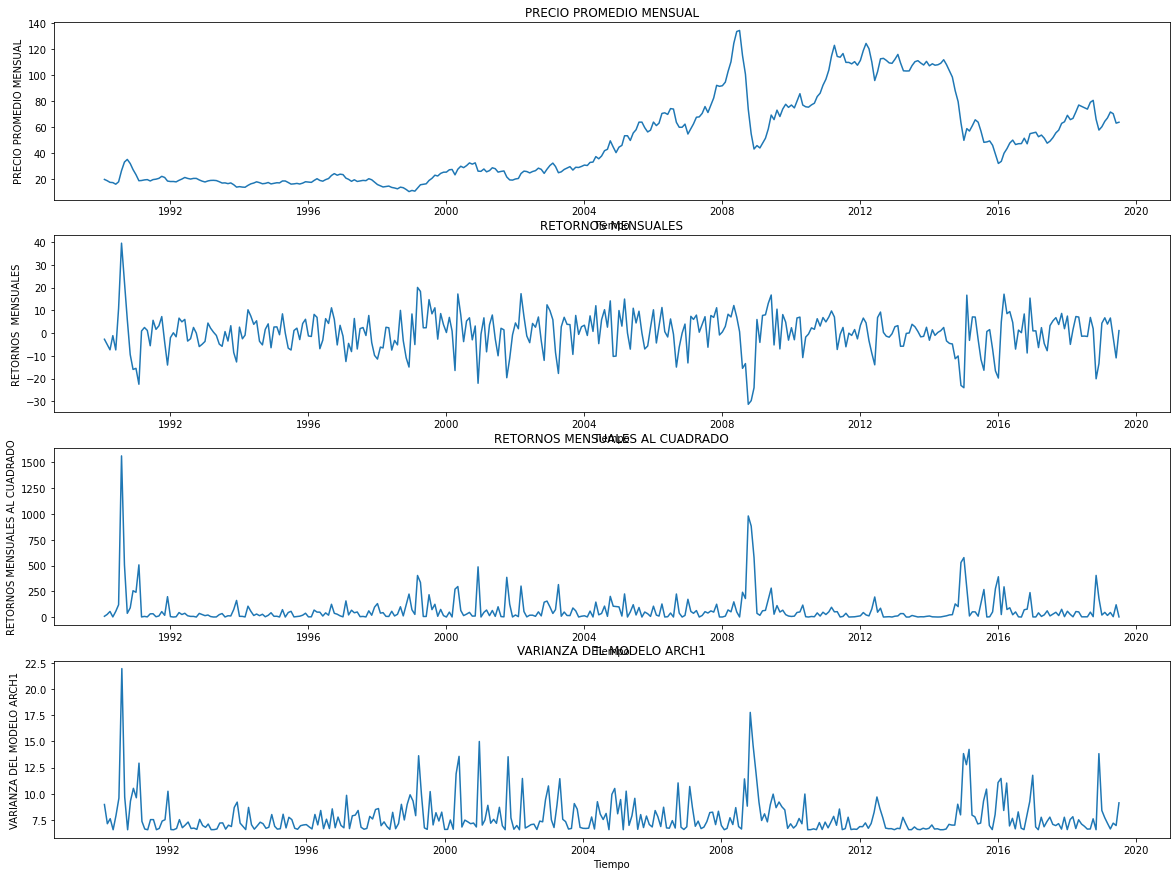

In [25]:
#Inspección gráfica

fig, ax =plt.subplots(4,1, figsize=(20, 15), sharex = False)

#PRECIO
sns.lineplot(y = df.PRECIO, x = df.index, dashes= True, err_style ="bars", ax = ax[0])
ax[0].set_xlabel('Tiempo', fontsize=10)
ax[0].set_ylabel('PRECIO PROMEDIO MENSUAL', fontsize=10)
ax[0].set_title("PRECIO PROMEDIO MENSUAL", fontsize=12)

#RETORNOS
sns.lineplot(y = df.RETP, x = df.index, dashes= True, err_style ="bars", ax = ax[1])
ax[1].set_xlabel('Tiempo', fontsize=10)
ax[1].set_ylabel('RETORNOS  MENSUALES', fontsize=10)
ax[1].set_title("RETORNOS MENSUALES", fontsize=12)


#RETORNOS2
sns.lineplot(y = df.RETP2, x = df.index, dashes= True, err_style ="bars", ax = ax[2])
ax[2].set_xlabel('Tiempo', fontsize=10)
ax[2].set_ylabel('RETORNOS MENSUALES AL CUADRADO', fontsize=10)
ax[2].set_title("RETORNOS MENSUALES AL CUADRADO", fontsize=12)

#RETORNOS2
sns.lineplot(y = arch1.conditional_volatility[1:] , x = arch1.conditional_volatility[1:].index, dashes= True, err_style ="bars", ax = ax[3])
ax[3].set_xlabel('Tiempo', fontsize=10)
ax[3].set_ylabel('VARIANZA DEL MODELO ARCH1', fontsize=10)
ax[3].set_title("VARIANZA DEL MODELO ARCH1", fontsize=12)

In [26]:
#PRONOSTICO DE LA VARIANZA CONDICIONAL

In [27]:
forecast_arch1 = arch1.forecast(horizon=17)

In [28]:
pronostico_std = np.sqrt(forecast_arch1.variance[-1:]).T #sacamos la raíz cuadrado y la transponemos
pronostico_std.columns = ["pronostico"] #cambiamos el nombre a pronostico
pronostico_std.index = pd.date_range('2019-08-01','2020-12-07', freq='MS').strftime("%Y-%m-%d").tolist()
pronostico_std = pd.concat([arch1_std[-1:], pronostico_std["pronostico"] ])

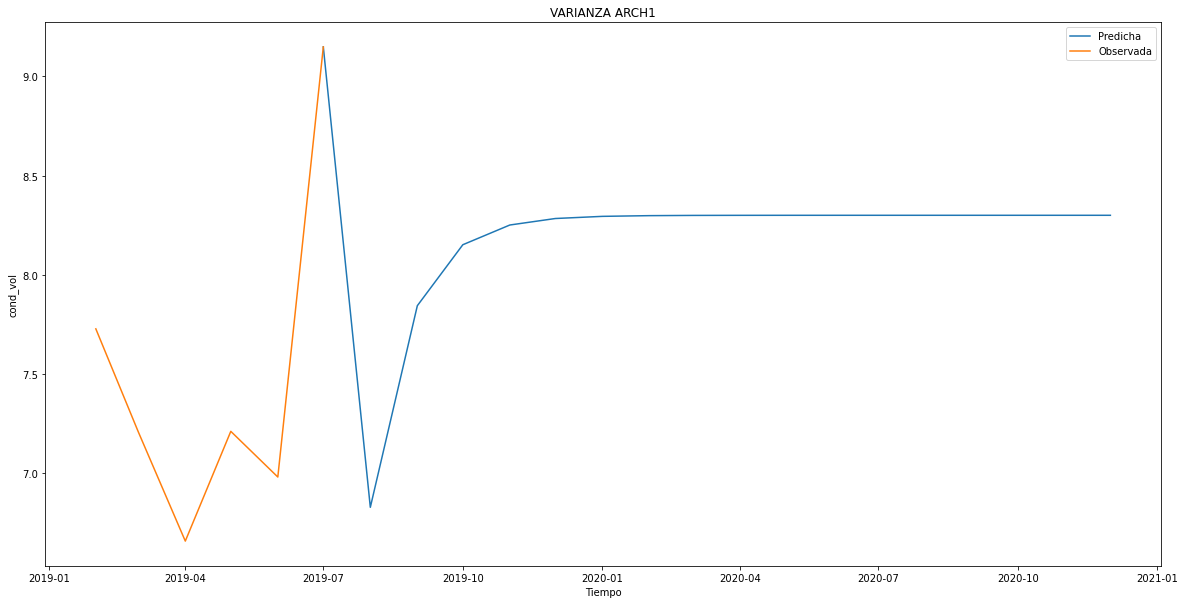

In [29]:
#Inspección gráfica

fig, ax =plt.subplots(1,1, figsize=(20, 10), sharex = False)

#PRECIO
sns.lineplot(y = pronostico_std, x = pronostico_std.index, dashes= True, err_style ="bars", ax = ax)
sns.lineplot(y = arch1_std[348:], x = arch1_std[348:].index, dashes= True, err_style ="bars", ax = ax)
ax.set_xlabel('Tiempo', fontsize=10)
ax.set_title("VARIANZA ARCH1", fontsize=12)
ax.legend(["Predicha", "Observada"])

### GARCH

In [30]:
garch1 = arch.univariate.ARX(df.RETP, lags = [1], volatility = arch.univariate.GARCH(1, 0, 1) ).fit()
print("\n", garch1.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8086.718480846172
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1575.9845901772028
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1254.2944520292554
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1221.064422179782
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1219.526539767935
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1219.5692887052596
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1219.760409460121
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1219.496155243007
Iteration:      9,   Func. Count:     64,   Neg. LLF: 1219.4961150542101
Iteration:     10,   Func. Count:     70,   Neg. LLF: 1219.4961139250775
Iteration:     11,   Func. Count:     75,   Neg. LLF: 1219.4961139250522
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1219.4961139250775
            Iterations: 11
            Function evaluations: 75
            Gradient evaluati

¿Cómo se ve la varianza predicha vs la observada?

In [31]:
varianza_garch1 = residuales2 - garch1.resid

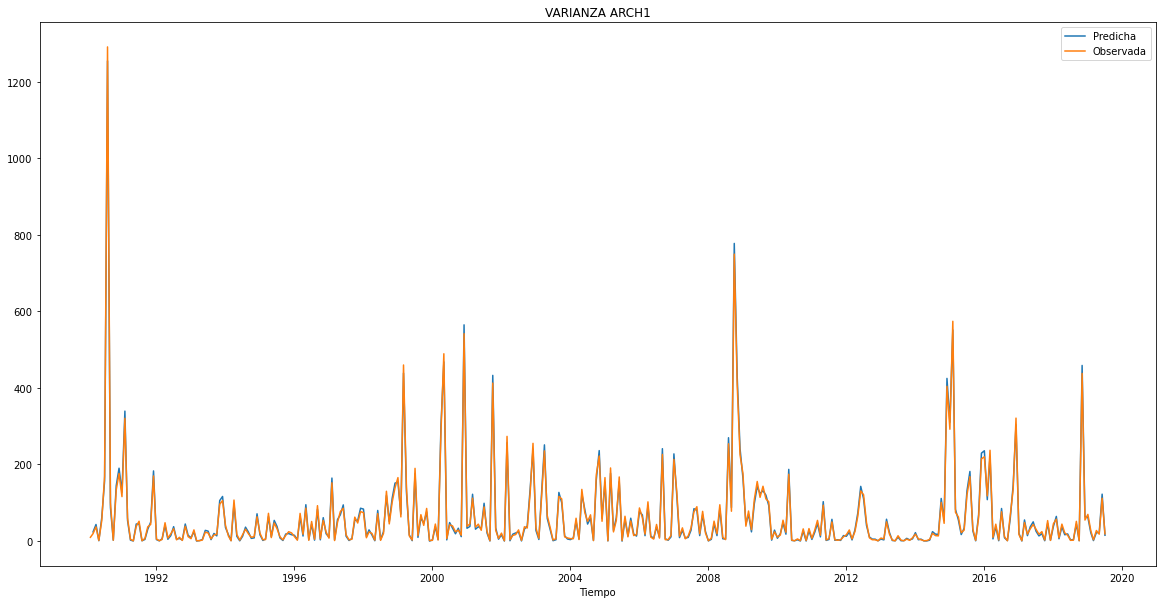

In [32]:
#Inspección gráfica

fig, ax =plt.subplots(1,1, figsize=(20, 10), sharex = False)

#PRECIO
sns.lineplot(y = varianza_garch1, x = varianza_garch1.index, dashes= True, err_style ="bars", ax = ax)
sns.lineplot(y = residuales2, x = residuales2.index, dashes= True, err_style ="bars", ax = ax)
ax.set_xlabel('Tiempo', fontsize=10)
ax.set_title("VARIANZA ARCH1", fontsize=12)
ax.legend(["Predicha", "Observada"])

Veamos el comportamiento de los errores

In [33]:
garch1_resid = garch1.resid
garch1_std = garch1.conditional_volatility
garch1_resid_std = garch1_resid / garch1_std
garch1_resid_std = garch1_resid_std[1:]

In [34]:
import statsmodels.api as sm

Text(0.5, 1.0, 'ACF Errores Estandarizados^2')

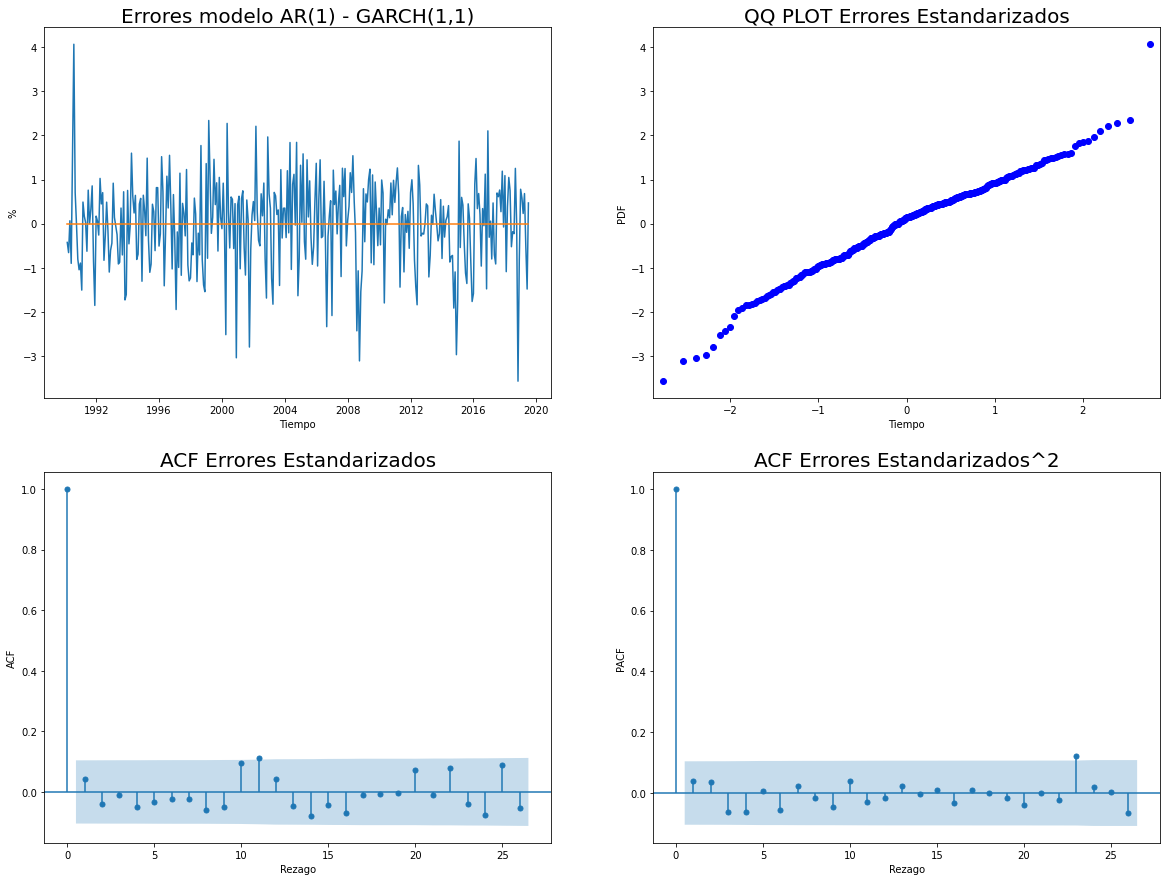

In [35]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = garch1_resid_std , x = garch1_resid_std.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(garch1_resid_std)),  x = garch1_resid_std.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('%', fontsize=10)
ax[0,0].set_title('Errores modelo AR(1) - GARCH(1,1)', fontsize=20)


sm.qqplot(garch1_resid_std, ax=ax[0,1])
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PDF', fontsize=10)
ax[0,1].set_title('QQ PLOT Errores Estandarizados', fontsize=20)


#FIG 1
plot_acf(garch1_resid_std, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)
ax[1,0].set_title('ACF Errores Estandarizados', fontsize=20)

#FIG 2
plot_acf(garch1_resid_std**2, ax = ax[1,1], alpha = 0.05)
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10) 
ax[1,1].set_title('ACF Errores Estandarizados^2', fontsize=20)

### Q-test

In [36]:
A = pd.DataFrame() #creamos un dataframe vacío

for i in range(5,16,5): #en un rango del 1 al 15 de 5 en 5 (...)
    B  = QTest(garch1_resid_std**2, lags=[i], return_df=True) #Estimamos la prueba para cada uno de los rezagos y (...)
    A = pd.concat([A,B]) # la concatenamos verticalmente con las demás pruebas

A

,lb_stat,lb_pvalue
5,3.932381,0.559192
10,6.778295,0.746196
15,7.496102,0.942395


Text(0.5, 1.0, 'VARIANZA DEL MODELO ARCH1')

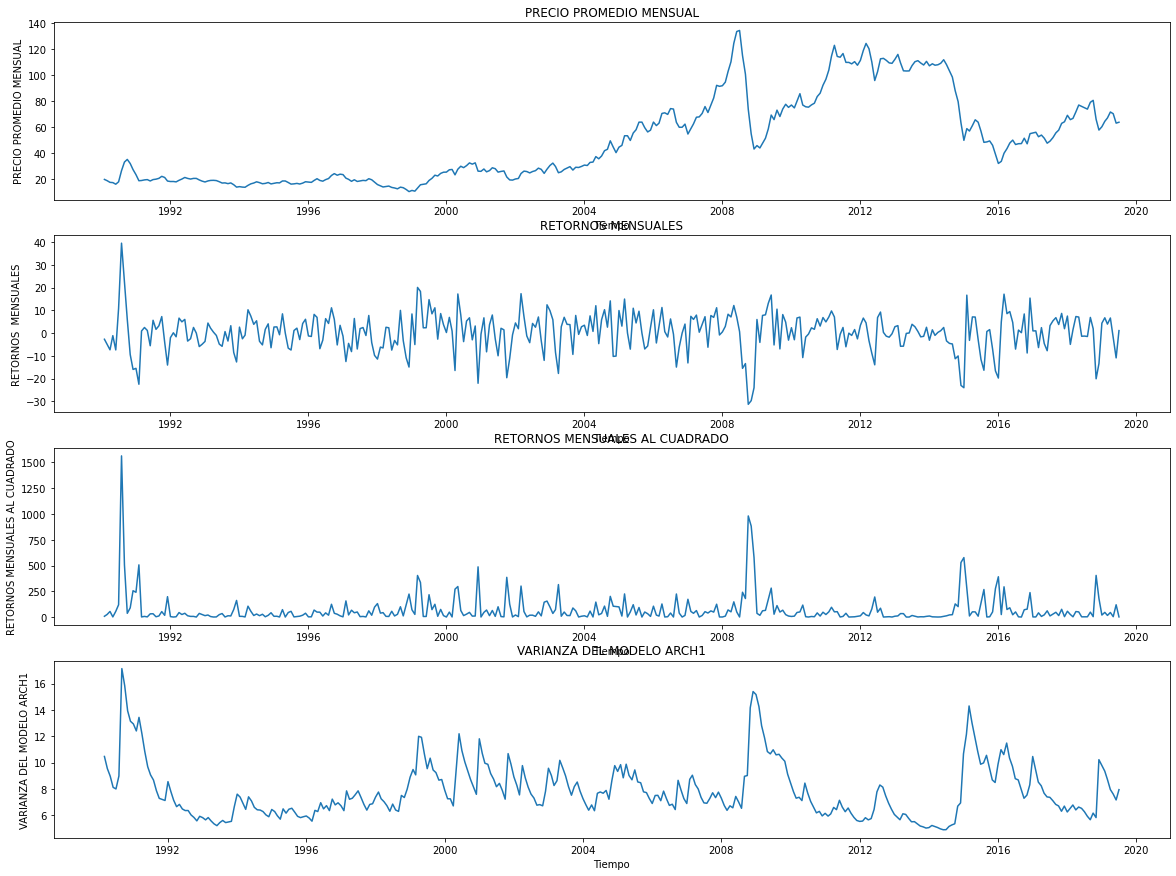

In [37]:
#Inspección gráfica

fig, ax =plt.subplots(4,1, figsize=(20, 15), sharex = False)

#PRECIO
sns.lineplot(y = df.PRECIO, x = df.index, dashes= True, err_style ="bars", ax = ax[0])
ax[0].set_xlabel('Tiempo', fontsize=10)
ax[0].set_ylabel('PRECIO PROMEDIO MENSUAL', fontsize=10)
ax[0].set_title("PRECIO PROMEDIO MENSUAL", fontsize=12)

#RETORNOS
sns.lineplot(y = df.RETP, x = df.index, dashes= True, err_style ="bars", ax = ax[1])
ax[1].set_xlabel('Tiempo', fontsize=10)
ax[1].set_ylabel('RETORNOS  MENSUALES', fontsize=10)
ax[1].set_title("RETORNOS MENSUALES", fontsize=12)


#RETORNOS2
sns.lineplot(y = df.RETP2, x = df.index, dashes= True, err_style ="bars", ax = ax[2])
ax[2].set_xlabel('Tiempo', fontsize=10)
ax[2].set_ylabel('RETORNOS MENSUALES AL CUADRADO', fontsize=10)
ax[2].set_title("RETORNOS MENSUALES AL CUADRADO", fontsize=12)

#RETORNOS2
sns.lineplot(y = garch1.conditional_volatility[1:] , x = arch1.conditional_volatility[1:].index, dashes= True, err_style ="bars", ax = ax[3])
ax[3].set_xlabel('Tiempo', fontsize=10)
ax[3].set_ylabel('VARIANZA DEL MODELO ARCH1', fontsize=10)
ax[3].set_title("VARIANZA DEL MODELO ARCH1", fontsize=12)

In [38]:
#PRONOSTICO DE LA VARIANZA CONDICIONAL

In [39]:
forecast_garch1 = garch1.forecast(horizon=17)

In [40]:
pronostico_gstd = np.sqrt(forecast_garch1.variance[-1:]).T #sacamos la raíz cuadrado y la transponemos
pronostico_gstd.columns = ["pronostico"] #cambiamos el nombre a pronostico
pronostico_gstd.index = pd.date_range('2019-08-01','2020-12-07', freq='MS').strftime("%Y-%m-%d").tolist()
pronostico_gstd = pd.concat([garch1_std[-1:], pronostico_gstd["pronostico"] ])

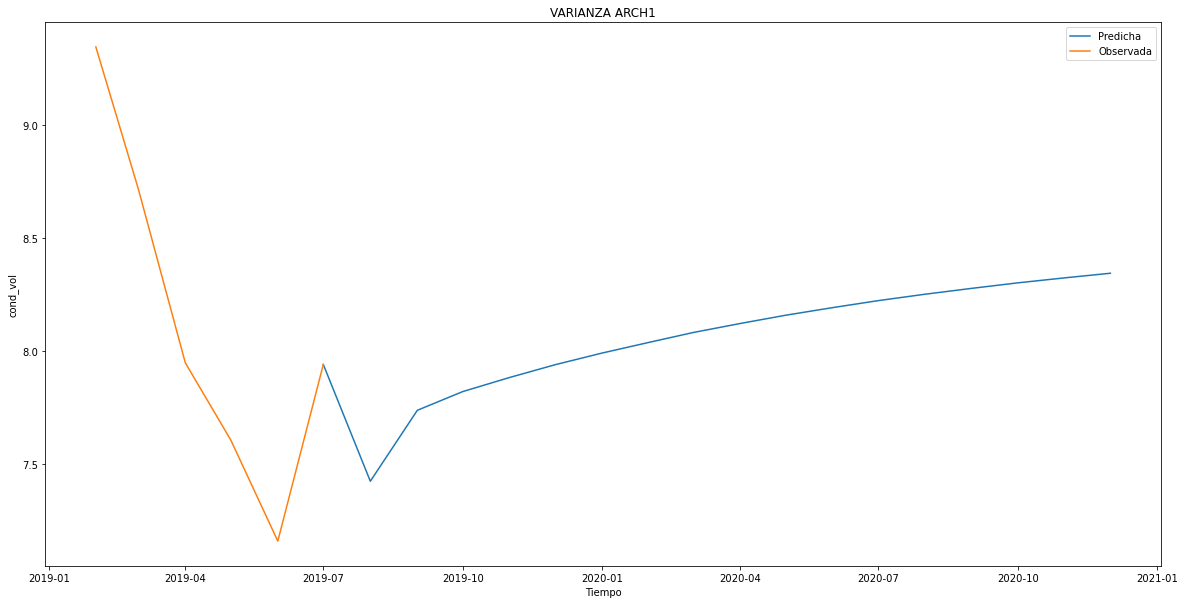

In [41]:
#Inspección gráfica

fig, ax =plt.subplots(1,1, figsize=(20, 10), sharex = False)

#PRECIO
sns.lineplot(y = pronostico_gstd, x = pronostico_gstd.index, dashes= True, err_style ="bars", ax = ax)
sns.lineplot(y = garch1_std[348:], x = garch1_std[348:].index, dashes= True, err_style ="bars", ax = ax)
ax.set_xlabel('Tiempo', fontsize=10)
ax.set_title("VARIANZA ARCH1", fontsize=12)
ax.legend(["Predicha", "Observada"])

### G - GARCH

In [42]:
Tgarch1 = arch.univariate.ARX(df.RETP, lags = [1], volatility = arch.univariate.GARCH(1, 1, 1) ).fit()
print("\n", Tgarch1.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 47210.701108970985
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1246.5624995467565
Iteration:      3,   Func. Count:     27,   Neg. LLF: 1233.3747685802928
Iteration:      4,   Func. Count:     35,   Neg. LLF: 1220.368680248021
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1218.6638922556365
Iteration:      6,   Func. Count:     51,   Neg. LLF: 1218.4313830323686
Iteration:      7,   Func. Count:     58,   Neg. LLF: 1218.4287899458664
Iteration:      8,   Func. Count:     66,   Neg. LLF: 1218.4121719869706
Iteration:      9,   Func. Count:     73,   Neg. LLF: 1218.3822624808688
Iteration:     10,   Func. Count:     80,   Neg. LLF: 1218.2839505324646
Iteration:     11,   Func. Count:     87,   Neg. LLF: 1218.1368909470712
Iteration:     12,   Func. Count:     94,   Neg. LLF: 1218.033123217151
Iteration:     13,   Func. Count:    101,   Neg. LLF: 1217.9083667828413
Iteration:     14,   Func. Count:    108,   Neg. LLF:

¿Cómo se ve la varianza predicha vs la observada?

In [43]:
varianza_Tgarch1 = residuales2 - Tgarch1.resid

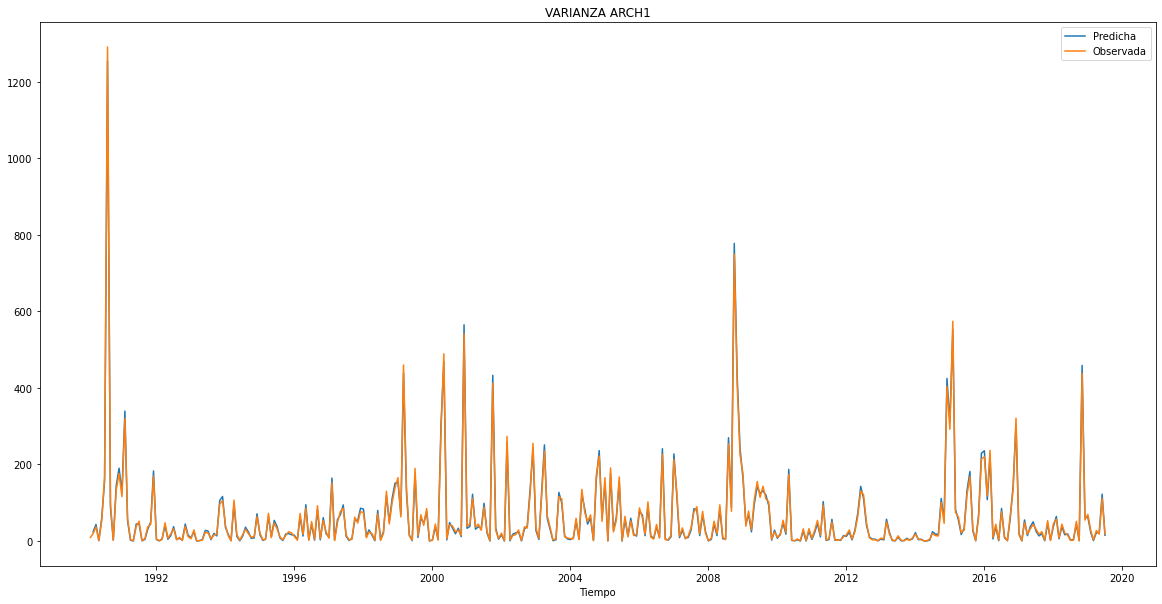

In [44]:
#Inspección gráfica

fig, ax =plt.subplots(1,1, figsize=(20, 10), sharex = False)

#PRECIO
sns.lineplot(y = varianza_Tgarch1, x = varianza_Tgarch1.index, dashes= True, err_style ="bars", ax = ax)
sns.lineplot(y = residuales2, x = residuales2.index, dashes= True, err_style ="bars", ax = ax)
ax.set_xlabel('Tiempo', fontsize=10)
ax.set_title("VARIANZA ARCH1", fontsize=12)
ax.legend(["Predicha", "Observada"])

Veamos el comportamiento de los errores

In [45]:
Tgarch1_resid = Tgarch1.resid
Tgarch1_std = Tgarch1.conditional_volatility
Tgarch1_resid_std = Tgarch1_resid / Tgarch1_std
Tgarch1_resid_std = Tgarch1_resid_std[1:]

In [46]:
import statsmodels.api as sm

Text(0.5, 1.0, 'ACF Errores Estandarizados^2')

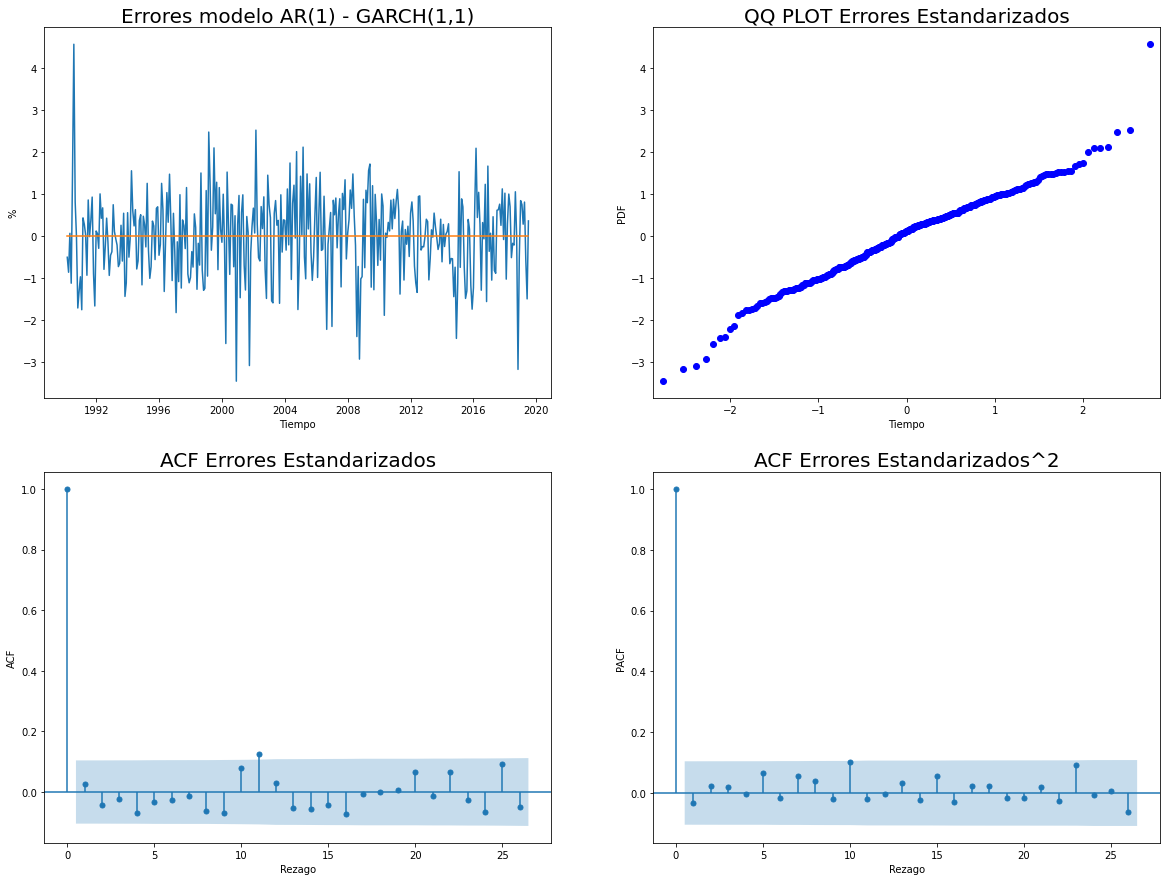

In [47]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

#FIG 0,0
sns.lineplot(y = Tgarch1_resid_std , x = Tgarch1_resid_std.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(Tgarch1_resid_std)),  x = Tgarch1_resid_std.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('Tiempo', fontsize=10)
ax[0,0].set_ylabel('%', fontsize=10)
ax[0,0].set_title('Errores modelo AR(1) - GARCH(1,1)', fontsize=20)


sm.qqplot(Tgarch1_resid_std, ax=ax[0,1])
ax[0,1].set_xlabel('Tiempo', fontsize=10)
ax[0,1].set_ylabel('PDF', fontsize=10)
ax[0,1].set_title('QQ PLOT Errores Estandarizados', fontsize=20)


#FIG 1
plot_acf(Tgarch1_resid_std, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)
ax[1,0].set_title('ACF Errores Estandarizados', fontsize=20)

#FIG 2
plot_acf(Tgarch1_resid_std**2, ax = ax[1,1], alpha = 0.05)
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10) 
ax[1,1].set_title('ACF Errores Estandarizados^2', fontsize=20)

### Q-test

In [48]:
A = pd.DataFrame() #creamos un dataframe vacío

for i in range(5,16,5): #en un rango del 1 al 15 de 5 en 5 (...)
    B  = QTest(Tgarch1_resid_std**2, lags=[i], return_df=True) #Estimamos la prueba para cada uno de los rezagos y (...)
    A = pd.concat([A,B]) # la concatenamos verticalmente con las demás pruebas

A

,lb_stat,lb_pvalue
5,2.334588,0.801174
10,8.115513,0.617555
15,10.033228,0.817645


Text(0.5, 1.0, 'VARIANZA DEL MODELO T_GARCH1')

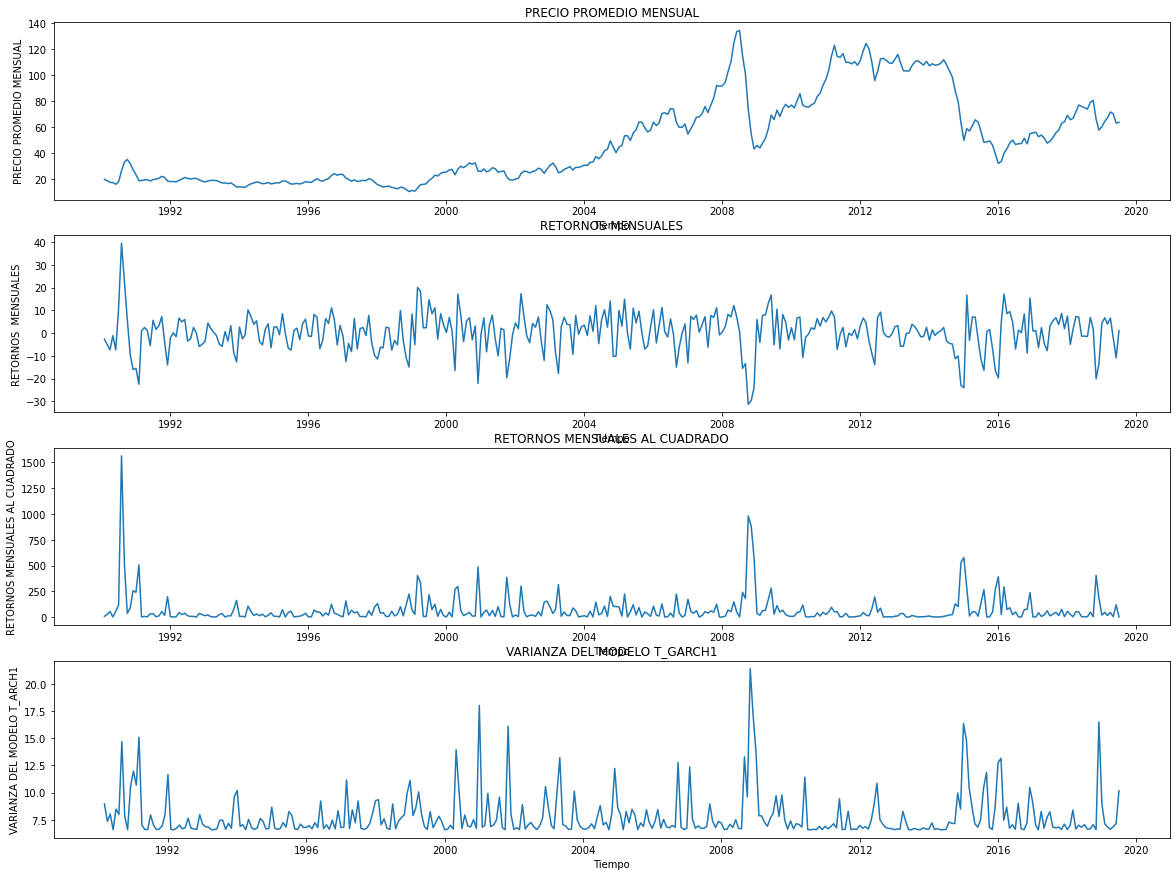

In [49]:
#Inspección gráfica

fig, ax =plt.subplots(4,1, figsize=(20, 15), sharex = False)

#PRECIO
sns.lineplot(y = df.PRECIO, x = df.index, dashes= True, err_style ="bars", ax = ax[0])
ax[0].set_xlabel('Tiempo', fontsize=10)
ax[0].set_ylabel('PRECIO PROMEDIO MENSUAL', fontsize=10)
ax[0].set_title("PRECIO PROMEDIO MENSUAL", fontsize=12)

#RETORNOS
sns.lineplot(y = df.RETP, x = df.index, dashes= True, err_style ="bars", ax = ax[1])
ax[1].set_xlabel('Tiempo', fontsize=10)
ax[1].set_ylabel('RETORNOS  MENSUALES', fontsize=10)
ax[1].set_title("RETORNOS MENSUALES", fontsize=12)


#RETORNOS2
sns.lineplot(y = df.RETP2, x = df.index, dashes= True, err_style ="bars", ax = ax[2])
ax[2].set_xlabel('Tiempo', fontsize=10)
ax[2].set_ylabel('RETORNOS MENSUALES AL CUADRADO', fontsize=10)
ax[2].set_title("RETORNOS MENSUALES AL CUADRADO", fontsize=12)

#RETORNOS2
sns.lineplot(y = Tgarch1.conditional_volatility[1:] , x = Tgarch1.conditional_volatility[1:].index, dashes= True, err_style ="bars", ax = ax[3])
ax[3].set_xlabel('Tiempo', fontsize=10)
ax[3].set_ylabel('VARIANZA DEL MODELO T_ARCH1', fontsize=10)
ax[3].set_title("VARIANZA DEL MODELO T_GARCH1", fontsize=12)

In [50]:
#PRONOSTICO DE LA VARIANZA CONDICIONAL

In [51]:
forecast_Tgarch1 = Tgarch1.forecast(horizon=17)

In [52]:
pronostico_Tgstd = np.sqrt(forecast_Tgarch1.variance[-1:]).T #sacamos la raíz cuadrado y la transponemos
pronostico_Tgstd.columns = ["pronostico"] #cambiamos el nombre a pronostico
pronostico_Tgstd.index = pd.date_range('2019-08-01','2020-12-07', freq='MS').strftime("%Y-%m-%d").tolist()
pronostico_Tgstd = pd.concat([Tgarch1_std[-1:], pronostico_Tgstd["pronostico"] ])

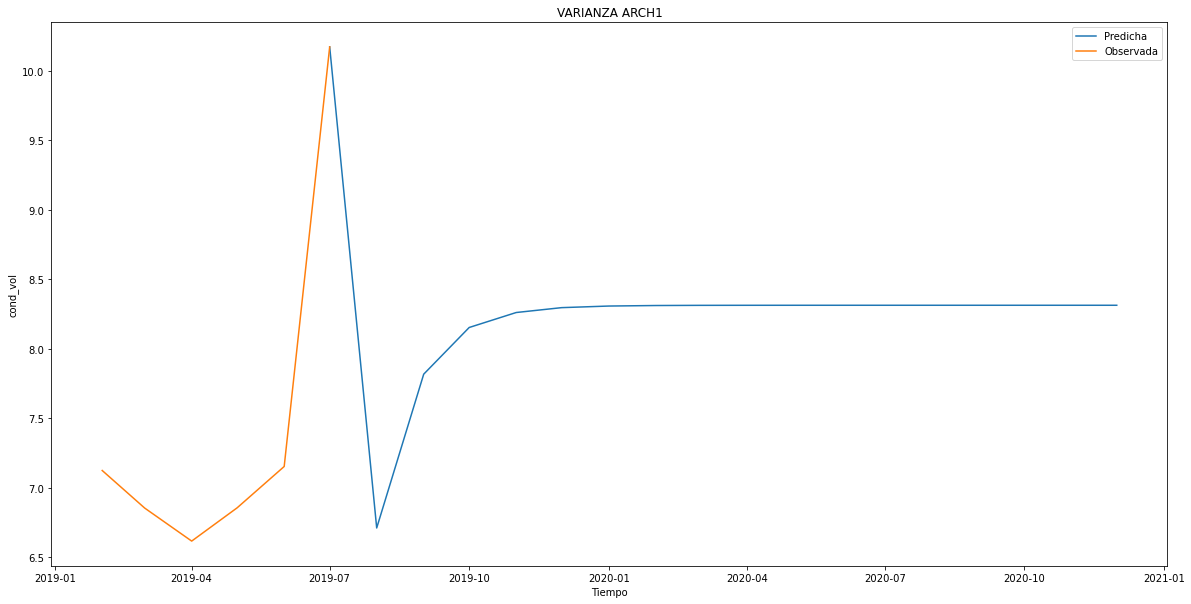

In [53]:
#Inspección gráfica

fig, ax =plt.subplots(1,1, figsize=(20, 10), sharex = False)

#PRECIO
sns.lineplot(y = pronostico_Tgstd, x = pronostico_Tgstd.index, dashes= True, err_style ="bars", ax = ax)
sns.lineplot(y = Tgarch1_std[348:], x = Tgarch1_std[348:].index, dashes= True, err_style ="bars", ax = ax)
ax.set_xlabel('Tiempo', fontsize=10)
ax.set_title("VARIANZA ARCH1", fontsize=12)
ax.legend(["Predicha", "Observada"])

¿Cuál es el mejor modelo?

In [55]:
bic = [model1.bic, arch1.bic, garch1.bic, Tgarch1.bic]
aic = [model1.aic, arch1.aic, garch1.aic, Tgarch1.aic]

In [57]:
pd.DataFrame(zip(bic, aic), columns = ["BIC", "AIC"], index = ["AR1", "AR1-ARCH1", "AR1-GARCH(1,1)", "AR1-TGARCH1"])

,BIC,AIC
AR1,2492.460584,2480.852694
AR1-ARCH1,2465.266370,2449.800498
"AR1-GARCH(1,1)",2468.324568,2448.992228
AR1-TGARCH1,2470.995109,2447.796301


En cualquiera de los casos, los modelos de varianza condicional presentan menores criterios que el AR1. Si tenemos en cuenta el BIC el mejor modelo es el AR1-ARCH1 y si tenemos en consideración el AIC entonces el mejor es el AR1-TGARCH1.